In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import datetime
import tensorflow_probability as   tfp
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense,Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling,MaxPooling2D
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, FalseNegatives, FalsePositives, TrueNegatives, TruePositives, Precision, Recall, AUC, BinaryAccuracy
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2,L1
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
from google.colab import drive
import albumentations as A
from tensorboard.plugins.hparams import api as hp

from PIL import Image
import io
import os


In [ ]:

# Load Malaria dataset
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])



In [ ]:
def splits(dataset,TRAIN_RATIO,VAL_RATIO,TEST_RATIO):
  dataset_size=len(dataset)
  train_dataset=dataset.take(int(dataset_size*TRAIN_RATIO))
  val_test_dataset=dataset.skip(int(dataset_size*TRAIN_RATIO))
  val_dataset=val_test_dataset.take(int(VAL_RATIO*dataset_size))
  test_dataset=val_test_dataset.skip(int(VAL_RATIO*dataset_size))
  return train_dataset,val_dataset,test_dataset
TRAIN_RATIO=0.8
VAL_RATIO=0.1
TEST_RATIO=0.1

# dataset=tf.data.Dataset.range(10)
train_dataset,val_dataset,test_dataset=splits(dataset[0],TRAIN_RATIO,VAL_RATIO,TEST_RATIO)
# print(list(train_dataset.take(1).as_numpy_iterator()),list(val_dataset.take(1).as_numpy_iterator()),list(test_dataset.take(1).as_numpy_iterator()))

In [ ]:
# Data Augmentation function
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Apply preprocessing and augmentation
train_dataset=train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).map(preprocess).map(augment).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset=val_dataset.map(preprocess).batch(32)




In [ ]:
# Step 3: Define Multiple Models

# Sequential Model
def build_sequential_model():
    model = tf.keras.Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Functional API Model
def build_functional_model():
    inputs = Input(shape=(224, 224, 3))
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Custom Model
class CustomModel(tf.keras.Model):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv1 = Conv2D(32, (3, 3), activation='relu')
        self.pool1 = MaxPooling2D(2, 2)
        self.conv2 = Conv2D(64, (3, 3), activation='relu')
        self.pool2 = MaxPooling2D(2, 2)
        self.flatten = Flatten()
        self.d1 = Dense(512, activation='relu')
        self.d2 = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

    def build_graph(self):
        x = Input(shape=(224, 224, 3))
        return Model(inputs=[x], outputs=self.call(x))

# Create instances of each model
sequential_model = build_sequential_model()
functional_model = build_functional_model()
custom_model = CustomModel()

In [ ]:

def train_model(model, epochs=10):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)
    return history

# Train and store metrics
models = {
    'Sequential': sequential_model,
    'Functional': functional_model,
    'Custom': custom_model
}
histories = {name: train_model(model) for name, model in models.items()}

Epoch 1/10
689/689 [==============================] - 71s 94ms/step - loss: 0.4301 - accuracy: 0.8471 - val_loss: 0.1891 - val_accuracy: 0.9347
Epoch 2/10
689/689 [==============================] - 63s 92ms/step - loss: 0.1888 - accuracy: 0.9403 - val_loss: 0.1581 - val_accuracy: 0.9535
Epoch 3/10
689/689 [==============================] - 55s 80ms/step - loss: 0.1889 - accuracy: 0.9390 - val_loss: 0.1627 - val_accuracy: 0.9477
Epoch 4/10
689/689 [==============================] - 63s 91ms/step - loss: 0.1653 - accuracy: 0.9467 - val_loss: 0.1734 - val_accuracy: 0.9434
Epoch 5/10
689/689 [==============================] - 55s 80ms/step - loss: 0.1518 - accuracy: 0.9496 - val_loss: 0.2054 - val_accuracy: 0.9321
Epoch 6/10
689/689 [==============================] - 63s 92ms/step - loss: 0.1432 - accuracy: 0.9526 - val_loss: 0.1489 - val_accuracy: 0.9543
Epoch 7/10
689/689 [==============================] - 63s 92ms/step - loss: 0.1375 - accuracy: 0.9541 - val_loss: 0.1767 - val_accuracy:

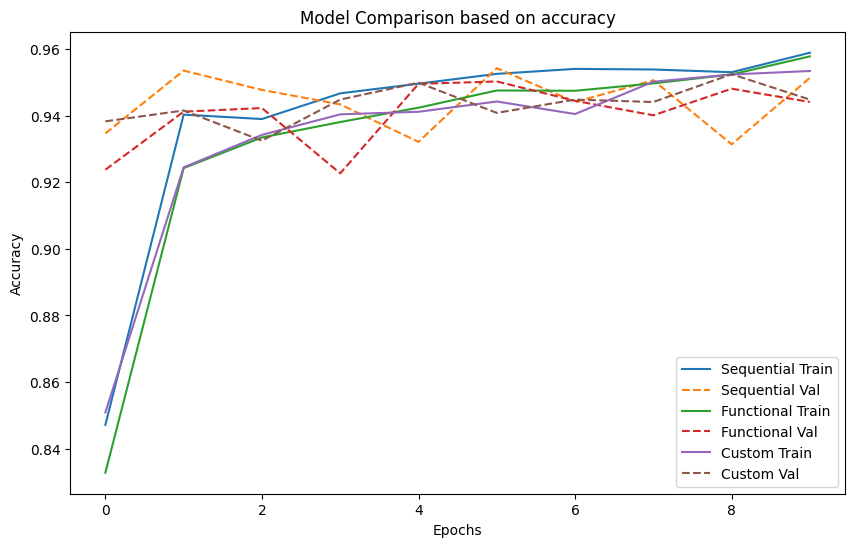

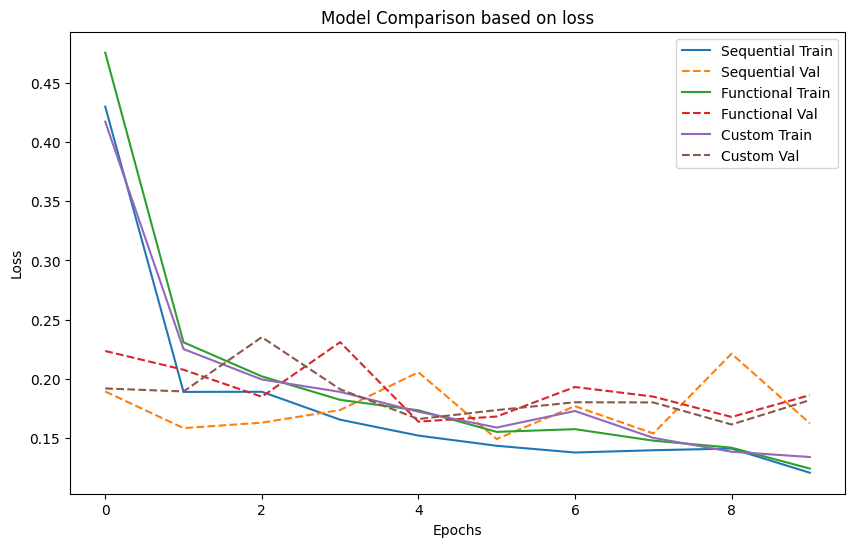

In [ ]:
def plot_metrics(histories, metric):
    plt.figure(figsize=(10, 6))
    for name, history in histories.items():
        plt.plot(history.history[metric], label=f'{name} Train')
        plt.plot(history.history[f'val_{metric}'], label=f'{name} Val', linestyle="--")

    plt.title(f'Model Comparison based on {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

# Plot for accuracy and loss
plot_metrics(histories, 'accuracy')
plot_metrics(histories, 'loss')


In [ ]:
final_results = {}
for name, history in histories.items():
    final_epoch = len(history.history['accuracy']) - 1
    final_results[name] = {
        'train_accuracy': history.history['accuracy'][final_epoch],
        'val_accuracy': history.history['val_accuracy'][final_epoch],
        'train_loss': history.history['loss'][final_epoch],
        'val_loss': history.history['val_loss'][final_epoch]
    }

# Print final results
for model_name, results in final_results.items():
    print(f"Results for {model_name}:")
    print(f"  Train Accuracy: {results['train_accuracy']}")
    print(f"  Validation Accuracy: {results['val_accuracy']}")
    print(f"  Train Loss: {results['train_loss']}")
    print(f"  Validation Loss: {results['val_loss']}\n")

Results for Sequential:
  Train Accuracy: 0.9589040875434875
  Validation Accuracy: 0.9513611793518066
  Train Loss: 0.12039068341255188
  Validation Loss: 0.16222183406352997

Results for Functional:
  Train Accuracy: 0.9578154683113098
  Validation Accuracy: 0.9441016316413879
  Train Loss: 0.123892642557621
  Validation Loss: 0.18598313629627228

Results for Custom:
  Train Accuracy: 0.95341557264328
  Validation Accuracy: 0.9448275566101074
  Train Loss: 0.13368664681911469
  Validation Loss: 0.18179114162921906

